# Study D
This notebook shows the full workflow for building models, simulating growth and obtaining SCFA predictions from data collected by the Gut Puzzle project in the Gibbons Lab, 2023

In [1]:
import pandas as pd
import numpy as np 
import scipy
import micom
import micom.measures
from plotnine import *

import os
%matplotlib inline

## Flux Calculation
Here we will calculate production rate from the experimental SCFA measurements and convert them to dicts for later use

In [2]:
scfas = pd.read_csv('../data/raw_data/studyD_original_scfas.csv', index_col = 0) # read original data 
scfas = scfas[scfas['Sample Description'].isin(['baseline','PBS', 'inulin', 'pectin'])] # isolate the fiber treatments we're interested in
scfas = scfas[scfas['Analyte'].isin(['Acetic acid', 'Butyric acid', 'Propionic acid'])] # isolate SCFA analytes
scfas['Analyte'] = scfas['Analyte'].str.replace('ic acid', 'ate') # rename analytes for consistency
scfas['Sample Description'] = scfas['Sample Description'].str.replace('PBS','control')
scfas = scfas.rename(columns = {'Client Sample ID':'sample_id', # rename columns for efficiency
                                'Sample Description':'treatment',
                                'Analyte':'analyte',
                                'Result':'flux'})
scfas = scfas[['donor_id','treatment','analyte','flux']] # isolate columns of interest
analyteBaseline =  scfas.groupby(['donor_id', 'analyte']).apply(lambda group: group[group['treatment'] == 'baseline']['flux'].mean()).reset_index() # calculate baseline
scfas = pd.merge(scfas, analyteBaseline, on=['donor_id', 'analyte']) # merge baselines onto SCFA dataframe
scfas.rename(columns = {0:'flux_baseline'}, inplace = True)
scfas['flux'] = scfas['flux'] - scfas['flux_baseline'] #calculate production from baseline
scfas = scfas[scfas['treatment'] != 'baseline'] #remove baselines
scfas = scfas.drop(columns=['flux_baseline']) #drop baseline column
scfas['sample_id'] = scfas['donor_id'].astype('str')+'_'+scfas['treatment'] # create unique identifier

scfas = scfas.groupby(['sample_id','donor_id','treatment','analyte']).mean().reset_index() # calculate means across replicates
scfas = pd.pivot(scfas, 
                       index = 'sample_id', 
                       columns = 'analyte',
                       values = 'flux') # pivot data for easy use
scfas.rename(columns = {'Acetate':'acetateMeasured',
                        'Butyrate':'butyrateMeasured',
                        'Propionate':'propionateMeasured'}, # rename columns for clarity
             inplace = True)
donors = scfas.index.str.split('_').str[0].unique() # get donor names
scfas[['acetateMeasured']] = scfas[['acetateMeasured']]/60.052 # divide production rate by molecular weight to get mmol/h 
scfas[['butyrateMeasured']] = scfas[['butyrateMeasured']]/88.1051
scfas[['propionateMeasured']] = scfas[['propionateMeasured']]/74.0785

scfas.to_csv('../data/studyD_scfas.csv')

## Taxonomy Table
We will read in abundance data for all samples. We will convert this into a taxnomy table to use in MICOM

In [3]:
abundance = pd.read_csv('../data/raw_data/studyD_original_abundance.csv')[['species','reads','sample']] # read in original abundance data
abundance.rename(columns = {'reads':'abundance','sample':'sample_id'}, inplace = True) # rename for consistency
# abundance['species'] = abundance['species'].str.replace(' ','_')
abundance['id'] = abundance['species'] # add id column to taxonomy table
abundance['id'] = abundance['id'].str.replace(' ', '_')
abundance['sample_id'] = abundance['sample_id'].astype('str') # type check
abundance = abundance.groupby(['sample_id','species','id']).sum().reset_index() #sum duplicates
table = pd.pivot_table(abundance, 
                       index = 'species',
                       columns = 'sample_id',
                       values = 'abundance') # pivot data into abundance matrix
table.fillna(0, inplace = True) #fill NaNs with 0 
table.to_csv('../data/studyD.csv')
abundance

,sample_id,species,id,abundance
0,7101,Abiotrophia defectiva,Abiotrophia_defectiva,118
1,7101,Acidaminococcus intestini,Acidaminococcus_intestini,45
2,7101,Actinomyces naeslundii,Actinomyces_naeslundii,210
3,7101,Actinomyces oris,Actinomyces_oris,214
4,7101,Actinomyces pacaensis,Actinomyces_pacaensis,92
...,...,...,...,...
8963,7128,[Clostridium] innocuum,[Clostridium]_innocuum,53138
8964,7128,[Clostridium] scindens,[Clostridium]_scindens,41561
8965,7128,[Ruminococcus] gnavus,[Ruminococcus]_gnavus,828841
8966,7128,[Ruminococcus] lactaris,[Ruminococcus]_lactaris,17641


## Build Models
Now, we'll build our models, with cutoff of 0.001

In [21]:
manifest = micom.workflows.build(abundance,
                                out_folder = '../models/studyD',
                                model_db = '../agora103_refseq216_species_1.qza',
                                cutoff = 0.001,
                                threads = 20)

Output()

## Load Medium
Load in the carbon-stripped European Diet, and construct the intervention diets by augmenting with inulin and pectin

In [4]:
medium = pd.read_csv('../media/studyDmedium.csv') # read medium 

controlMedium = medium # define control medium 

pectinMedium = pd.concat([medium,
                           pd.DataFrame({'reaction':['EX_pect_m'],
                                         'metabolite':['pect_m'],
                                         'global_id':['EX_pect(e)'],
                                         'flux':[1]
                                        },index = ['EX_pect_m'])]) # add pectin to treatment medium 


inulinMedium = pd.concat([medium,
                           pd.DataFrame({'reaction':['EX_inulin_m'],
                                         'metabolite':['inulin_m'],
                                         'global_id':['EX_inulin(e)'],
                                         'flux':[14]
                                        },index = ['EX_inulin_m'])]) # add inulin to treatment medium

medium

,Unnamed: 0.1,Unnamed: 0,reaction,metabolite,global_id,flux,name,molecular_weight,C_number,N_number,hmdb,inchi,kegg.compound,pubchem.compound,chebi,C_flux
0,EX_ac_m,1.0,EX_ac_m,ac_m,EX_ac(e),0.056450,acetate,59.04402,2.0,0.0,HMDB00042,"InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4)/p-1",C00033,176.0,NaN,1.129008
1,EX_acgam_m,2.0,EX_acgam_m,acgam_m,EX_acgam(e),0.010000,N-acetyl-D-glucosamine,221.20780,8.0,1.0,HMDB00215,InChI=1S/C8H15NO6/c1-4(12)9-5(2-10)7(14)8(15)6...,C00140,439174.0,NaN,0.800000
2,EX_ala_D_m,3.0,EX_ala_D_m,ala_D_m,EX_ala_D(e),0.010000,D-alanine,89.09318,3.0,1.0,HMDB01310,"InChI=1S/C3H7NO2/c1-2(4)3(5)6/h2H,4H2,1H3,(H,5...",C00133,71080.0,NaN,0.300000
3,EX_ala_L_m,4.0,EX_ala_L_m,ala_L_m,EX_ala_L(e),0.094786,L-alanine,89.09318,3.0,1.0,HMDB00161,"InChI=1S/C3H7NO2/c1-2(4)3(5)6/h2H,4H2,1H3,(H,5...",C00041,5950.0,NaN,2.843580
4,EX_amet_m,5.0,EX_amet_m,amet_m,EX_amet(e),0.010000,S-Adenosyl-L-methionine,399.44532,15.0,6.0,HMDB01185,NaN,C00019,34756.0,NaN,1.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,EX_strch1_m,NaN,EX_strch1_m,strch1_m,NaN,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,EX_strch2_m,NaN,EX_strch2_m,strch2_m,NaN,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,EX_starch1200_m,NaN,EX_starch1200_m,starch1200_m,NaN,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,EX_dextrin_m,NaN,EX_dextrin_m,dextrin_m,NaN,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Grow Models
Now we'll grow the samples using the respective media we constructed

In [7]:
manifest = pd.read_csv('../models/studyD/manifest.csv') # read manifest 
manifest = manifest[manifest['sample_id'].astype('str').isin(donors)] # filter to samples in SCFA data

controlGrowth = micom.workflows.grow(manifest, # grow samples for all treatments
                              '../models/studyD',
                              controlMedium,
                              tradeoff = 0.7,
                              strategy = 'none',
                              threads = 10)

pectinGrowth = micom.workflows.grow(manifest,
                              '../models/studyD',
                              pectinMedium,
                              tradeoff = 0.7,
                              strategy = 'none',
                              threads = 10)

inulinGrowth = micom.workflows.grow(manifest,
                              '../models/studyD',
                              inulinMedium,
                              tradeoff = 0.7,
                              strategy = 'none',
                              threads = 10)


Output()

Output()

Output()

## Compare SCFA Fluxes
We can now extract the production fluxes of SCFAs from each growth simulation, and construct a dataframe with both measured and predicted production rates.

In [8]:
inulinProduction = micom.measures.production_rates(inulinGrowth) # calculate production rates 
inulinProduction['sample_id'] = inulinProduction['sample_id']+'_inulin' # annotate sample ids with treatment 
pectinProduction = micom.measures.production_rates(pectinGrowth)
pectinProduction['sample_id'] = pectinProduction['sample_id']+'_pectin'
controlProduction = micom.measures.production_rates(controlGrowth)
controlProduction['sample_id'] = controlProduction['sample_id']+'_control'

production = pd.concat([inulinProduction,
                        pectinProduction, 
                        controlProduction]) # concatenate results 
res = production[(production['name']==('butyrate'))|
                 (production['name']==('acetate'))|
                 (production['name']==('propionate'))] # filter to SCFA production 
res = pd.pivot(res, index = 'sample_id',
                    columns = 'name',
                    values = 'flux') # pivot data
res.rename(columns = {'acetate':'acetatePredicted',
                      'butyrate':'butyratePredicted',
                      'propionate':'propionatePredicted'
                      }, inplace = True # rename columns for clarity 
          )

res['donor'] = res.index.str.split('_').str[0]
res['treatment'] = res.index.str.split('_').str[1]
res = pd.concat([res, scfas], axis = 1)
res['treatment'] = res['treatment'].str.capitalize()

## Plot Results
Finally, we'll plot predicted vs measured fluxes against each other

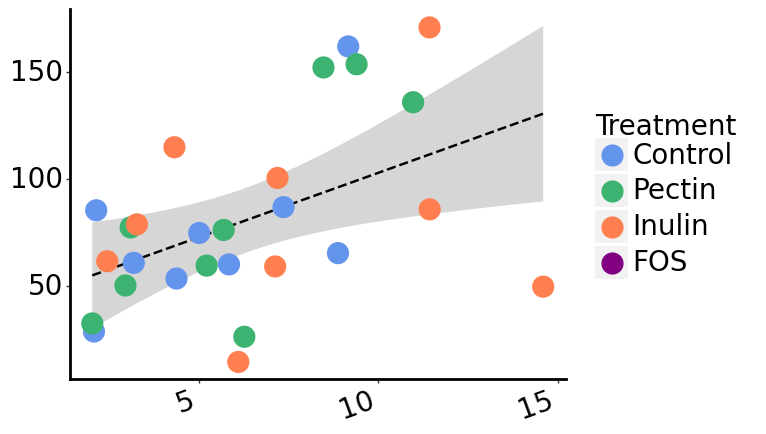

<ggplot: (8768659556283)>

In [10]:
fig1 = (ggplot(
    res, aes(x = 'butyrateMeasured', y = 'butyratePredicted'))
    +geom_smooth(method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 8)
    
    +scale_color_manual(limits = ['Control','Pectin','Inulin', 'FOS'], 
                        values = ['cornflowerblue', 'mediumseagreen', 'coral', 'purple'])
    +labs(title='Butyrate',
          x='Measured Butyrate (mmol/L/h)',
          y = 'Predicted Butyrate (mmol/gDW/h)',
          color = 'Treatment',fill = 'Treatment')
    +theme(text = element_text(size=20, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig1

In [14]:
scipy.stats.linregress(res['butyratePredicted'],
                       res['butyrateMeasured'])

LinregressResult(slope=0.037570942952104565, intercept=3.2755272457444815, rvalue=0.4749192320324774, pvalue=0.012306148697164199, stderr=0.013923855547531599, intercept_stderr=1.2641273628819094)

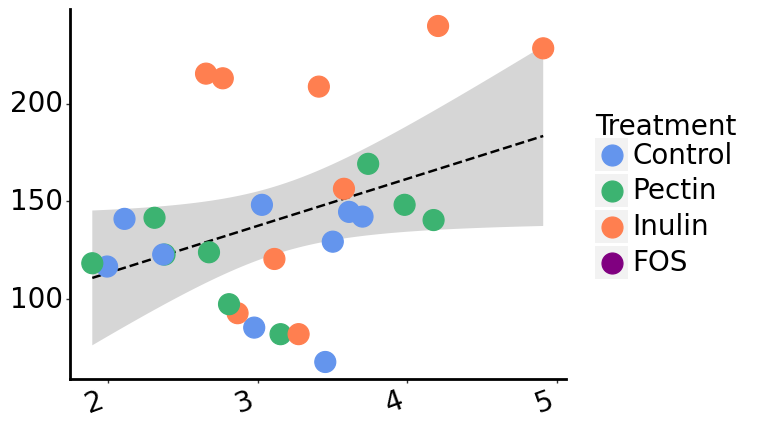

<ggplot: (8768659324142)>

In [11]:
fig2 = (ggplot(
    res, aes(x = 'propionateMeasured', y = 'propionatePredicted'))
    +geom_smooth(method = 'lm', linetype = '--')
    +geom_point(aes(color = 'treatment'), size = 8)
   
    +scale_color_manual(limits = ['Control','Pectin', 'Inulin', 'FOS'], 
                        values = ['cornflowerblue', 'mediumseagreen', 'coral', 'purple'])
    +labs(title='Propionate',
          x='Measured Propionate (mmol/L/h)',
          y = 'Predicted Propionate (mmol/gDW/h)',
          color = 'Treatment')
    +theme(text = element_text(size=20, color = 'black'),panel_background=element_rect(fill = "white",
                                    colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                    axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                    legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1))
)
fig2

In [12]:
scipy.stats.linregress(res['propionatePredicted'],
                       res['propionateMeasured'])

LinregressResult(slope=0.006036117866181473, intercept=2.2848640007436223, rvalue=0.3815724088037568, pvalue=0.049539476687240104, stderr=0.002924435168504747, intercept_stderr=0.4324754834006681)

In [15]:
res.to_csv('../results/studyD.csv') # save to results directory